In [2]:
import os
import torch
from matplotlib import pyplot as plt
from transformers import Owlv2ForObjectDetection, Owlv2Processor
import numpy as np
import numpy.ma as ma
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import skimage
from skimage import io as skimage_io
from skimage import transform as skimage_transform
from PIL import Image
from itertools import chain
from tqdm import tqdm
import pandas as pd
import json

## Create Datasets

In [ ]:
batch_size = 16
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataset = 'imagenet'
root = # '/path/to/'

In [7]:
class DRORDataset(Dataset):
    def __init__(self, root, cat2id, rat2id, processor):
        super().__init__()
        
        self.root = root
        self.cat2id = cat2id
        self.rat2id = rat2id
        self.processor = processor

        self.cat_names = os.listdir(self.root)
        self.images = []
        self.rationales = []
        self.categories = []
        self.max_length_rats = 0
        self.toTensor = transforms.ToTensor()

        self.extract_all()
        
        self.id2image = dict(zip(range(len(self.images)), self.images))

    def extract_all(self):
        for cat_name in self.cat_names:
            att_names = os.listdir(os.path.join(self.root, cat_name))
            if self.max_length_rats < len(att_names):
                self.max_length_rats = len(att_names)
                
            category = cat_name.strip().replace('_',' ').replace('-', ' ').replace('/',' or ').lower()
            
            for att_name in att_names:
                att_dir = os.path.join(self.root, cat_name, att_name)
                rationale = att_name.strip().replace('_',' ').replace('-', ' ').replace('/',' or ').lower()
                
                for each in os.listdir(att_dir):
                    if each == '0' or each == '1':
                        imgs_dir = os.path.join(att_dir, each)
                        images = os.listdir(imgs_dir)
                        self.images.extend([os.path.join(imgs_dir, image) for image in images])
                        self.categories.extend([self.cat2id[category]]*len(images))
                        #self.rationales.extend([self.rat2id[rationale]]*len(images))
                        self.rationales.extend([self.rat2id[self.cat2id[category]][rationale]]*len(images))
                    else:
                        raise Exception(f"Error: {cat_name}/{att_name}") 


    def __getitem__(self, index):
        image = Image.open(self.images[index])
        target_size = torch.Tensor(image.size[::-1])
        image = self.toTensor(image)
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)
            
        image = self.processor(images=image, return_tensors="pt")['pixel_values'].squeeze()
        
        category = self.categories[index]
        rationale = self.rationales[index]
        
        return image, target_size, category, rationale
    
    def __len__(self):
        return len(self.images)

In [ ]:
def create_json(root):
    cat_rat = {}
    for cat_name in os.listdir(root):
        category = cat_name.strip().replace('_',' ').replace('-', ' ').replace('/',' or ').lower()
        cat_rat[category] = []
        for att_name in os.listdir(os.path.join(root, cat_name)):
            
            rationale = att_name.strip().replace('_',' ').replace('-', ' ').replace('/',' or ').lower()
            cat_rat[category].append(rationale)

    return cat_rat

cat_rat = create_json(f'{root}/Datasets/{dataset}_dr/test')
cat2id = dict(zip(cat_rat.keys(), range(len(cat_rat.keys()))))
id2cat = dict(zip(cat2id.values(), cat2id.keys()))
all_rat = list(chain.from_iterable(cat_rat.values()))


rat2id = []
for cat, rats in cat_rat.items():
    rat2id.append(dict(zip(rats, range(len(rats)))))

id2rat = []
for cat, rats in cat_rat.items():
    id2rat.append(dict(zip(range(len(rats)), rats)))

In [9]:
processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")
model = model.to(device)

In [ ]:
testset = DRORDataset('{root}/Datasets/imagenet_dr/test', cat2id, rat2id, processor)
testLoader = DataLoader(testset, batch_size, num_workers=16)

trainset = DRORDataset('{root}/Datasets/imagenet_dr/train', cat2id, rat2id, processor)
trainLoader = DataLoader(trainset, batch_size, num_workers=16)

In [22]:
all_tokenized_cats = []
all_tokenized_rats = []
all_attention_masks_rats = []
all_attention_masks_cats = []

for cat, rats in cat_rat.items():
    processed_rats = processor(text=rats, return_tensors="pt", truncation=True)
    tokenized_rats = processed_rats['input_ids']
    attention_masks_rats = processed_rats['attention_mask']
    
    tokenized_rats = F.pad(tokenized_rats, (0,0,0,testset.max_length_rats-len(rats)), mode='constant', value=0)
    attention_masks_rats = F.pad(attention_masks_rats, (0,0,0,testset.max_length_rats-len(rats)), mode='constant', value=0)

    processed_cat = processor(text=cat, return_tensors="pt", truncation=True)
    tokenized_cat = processed_cat['input_ids']
    attention_masks_cat = processed_cat['attention_mask']

    all_tokenized_rats.append(tokenized_rats)
    all_attention_masks_rats.append(attention_masks_rats)

    all_tokenized_cats.append(tokenized_cat)
    all_attention_masks_cats.append(attention_masks_cat)


all_tokenized_rats = torch.stack(all_tokenized_rats)
all_attention_masks_rats = torch.stack(all_attention_masks_rats)
all_tokenized_cats = torch.cat(all_tokenized_cats, dim=0)
all_attention_masks_cats = torch.cat(all_attention_masks_cats, dim=0)


In [23]:
def create_dataset(dataLoader, Dataset, model, processor, all_tokenized_rats, all_attention_masks_rats, all_tokenized_cats, all_attention_masks_cats):
    with torch.no_grad():
        model.eval()
        dataset = []

        counter = 0
        for i, (imgs, target_sizes, cats, rats) in tqdm(enumerate(dataLoader), total=len(dataLoader)):
            imgs = imgs.to(device)
            target_sizes = target_sizes.to(device)

            rats_query = all_tokenized_rats[cats].to(device)
            att_rats = all_attention_masks_rats[cats].to(device)
            rats_query = rats_query.reshape(-1, rats_query.shape[-1])
            att_rats = att_rats.reshape(-1, att_rats.shape[-1])

            cats_query = all_tokenized_cats[cats].to(device)
            att_cats = all_attention_masks_cats[cats].to(device)

            outputs_rats = model(input_ids=rats_query, pixel_values=imgs, attention_mask=att_rats)
            outputs_cats = model(input_ids=cats_query, pixel_values=imgs, attention_mask=att_cats)
            
            results_rats = processor.post_process_object_detection(outputs_rats, threshold=0.1, target_sizes=target_sizes)
            results_cats = processor.post_process_object_detection(outputs_cats, threshold=0.1, target_sizes=target_sizes)

            for b in range(imgs.shape[0]):
                if len(results_rats[b]['scores'])==0 or len(results_cats[b]['scores'])==0:
                    continue
                
                data = {}
                data['image'] = Dataset.id2image[counter+b]
                data['category'] = id2cat[cats[b].item()]
                data['cat_boxes'] = results_cats[b]['boxes'].cpu().tolist()

                data['rationales'] = []
                data['rat_boxes'] = []

                for label, box in zip(results_rats[b]['labels'], results_rats[b]['boxes']):
                    data['rationales'].append(id2rat[cats[b].item()][label.item()])
                    data['rat_boxes'].append(box.cpu().tolist())
                
                data['unqiue_rationales'] = np.unique(data['rationales']).tolist()

                dataset.append(data)

            counter += imgs.shape[0]
        
        return dataset

In [ ]:
test_dataset = create_dataset(testLoader, testset, model, processor, all_tokenized_rats, all_attention_masks_rats, all_tokenized_cats, all_attention_masks_cats)
with open(f'{root}/Datasets/imagenet_dr/stats_test.json', 'w') as f:
    json.dump(test_dataset, f)

train_dataset = create_dataset(trainLoader, trainset, model, processor, all_tokenized_rats, all_attention_masks_rats, all_tokenized_cats, all_attention_masks_cats)
with open(f'{root}/Datasets/imagenet_dr/stats_train.json', 'w') as f:
    json.dump(train_dataset, f)

In [ ]:
with open(f'{root}/Datasets/imagenet_dr/stats_test.json', 'r') as f:
    test_dataset = json.load(f)

with open(f'{root}/Datasets/imagenet_dr/stats_train.json', 'r') as f:
    train_dataset = json.load(f)

In [34]:
print("Remained Part of Train set: ", len(train_dataset)/len(trainset))
print("Remained Part of Test set: ", len(test_dataset)/len(testset))

Remained Part of Train set:  0.8254393817597194
Remained Part of Test set:  0.7239015209709633


In [35]:
train_rat_len = []
for data in train_dataset:
    train_rat_len.append(len(data['unqiue_rationales']))

test_rat_len = []
for data in test_dataset:
    test_rat_len.append(len(data['unqiue_rationales']))

print("Train Average Ratinoales Length: ", np.mean(train_rat_len))
print("Test Average Ratinoales Length: ", np.mean(test_rat_len))

Train Average Ratinoales Length:  2.8700401161986444
Test Average Ratinoales Length:  2.869452181987001


## Sample

In [36]:
test_dataset[0].keys()

dict_keys(['image', 'category', 'cat_boxes', 'rationales', 'rat_boxes', 'unqiue_rationales'])

stretcher : ['a long, flat surface', 'often has wheels', 'used to transport injured or sick people']


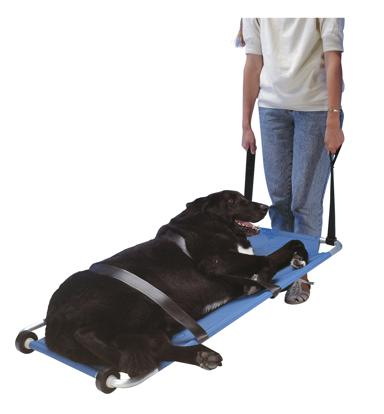

In [37]:
idx = np.random.choice(np.arange(len(test_dataset)))
sampled_data = test_dataset[idx]

print(sampled_data['category'], ':', sampled_data['unqiue_rationales'])
Image.open(sampled_data['image'])